# Discrete events

In [1]:
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Arc
from numpy import arange
from copy import deepcopy
from sympy import Symbol, nsolve

In [2]:
from pNeuma_simulator import params
from pNeuma_simulator.initialization import PoissonDisc

In [3]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "pdf.fonttype": 42,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica"],
        "mathtext.fontset": "stix",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
# LaTeX packages
plt.rc("text", usetex=False)
plt.rc(
    "text.latex",
    preamble=r"\usepackage{amsmath}",
)
plt.rc("text.latex", preamble=r"\usepackage{gensymb}")
dark_blue = "#1964B0"
dark_teal = "#008A69"
vermilion = "#DB5829"
orange = "#F4A637"
maroon = "#894B45"
dark_purple = "#882D71"
light_purple = "#D2BBD7"
grey = "#DEDEDE"

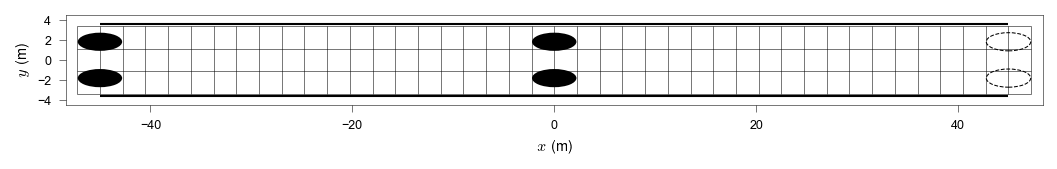

In [4]:
# Pseudorandom number generator
seed = 1024
rng = np.random.default_rng(seed)
n_cars = 2  # 14
n_moto = 0  # 12
# k = params.k
k = 128
sampler = PoissonDisc(
    n_cars, n_moto, cell=params.cell, L=params.L, W=params.cell * 3, k=k, clearance=params.clearance, rng=rng
)
samples, images = sampler.sample(rng)
c_samples = samples[: 2 * n_cars]
m_samples = samples[2 * n_cars :]
markings = arange(-sampler.W / 2, 3 * sampler.W / 4, sampler.W / 2)

fig, ax = plt.subplots(figsize=(2 * 8.7 * params.cm, 2.5 * params.cm), dpi=150)
ax.set_aspect("equal")
for sample in samples:
    if sample in c_samples:
        sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.6}
    else:
        sample.styles = {"ec": "k", "fill": False, "lw": 0.5}
    sample.draw(ax)
for image in images:
    image.styles = {"ec": "k", "fill": False, "lw": 0.5, "ls": "--"}
    image.draw(ax)
for m_sample in rng.choice(m_samples, n_moto, replace=False):
    m_sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.5}
    m_sample.draw(ax)
ax.hlines(
    [-params.lane, params.lane],
    xmin=-sampler.width / 2,
    xmax=sampler.width / 2,
    color="k",
    ls="-",
    lw=1,
)
ax.vlines(
    sampler.x_boundaries,
    ymin=-3 * sampler.cell / 2,
    ymax=3 * sampler.cell / 2,
    color="k",
    lw=0.25,
)
ax.hlines(
    sampler.y_boundaries,
    xmin=-sampler.nx * sampler.cell / 2,
    xmax=sampler.nx * sampler.cell / 2,
    color="k",
    lw=0.25,
)
plt.xlim(-(sampler.nx + 1) * sampler.cell / 2, (sampler.nx + 1) * sampler.cell / 2)
plt.ylim(-2 * sampler.cell, 2 * sampler.cell)
ax.set_xlabel("$x$ (m)", usetex=True)
ax.set_ylabel("$y$ (m)", usetex=True)
ax.set_yticks(arange(-4, 5, 2))
fig.tight_layout(pad=0)
# if n_moto == 0:
#    plt.savefig(f"darts_c{n_cars}m{n_moto}.pdf", format="pdf", transparent=True)
# else:
#    plt.savefig(f"darts_c{n_cars}m{n_moto}k{k}.pdf", format="pdf", transparent=True)

In [5]:
merger = samples[-2]

In [6]:
gamma = 15
theta = 2 * np.radians(gamma)
x_m = merger.x
y_m = merger.y
x_d = params.lane / np.tan(np.radians(gamma))
y_d = params.lane + y_m
x_c = x_d / 2
y_c = 0
x_0 = x_m
R = 0.5 * params.lane / (1 - np.cos(theta))
y_0 = R + y_m
r_min = R - params.car_w
r_max = R + params.car_w
s = 2 * R * theta

$\theta = \arccos{\left(1-0.5W/R\right)}$

$R = 0.5W/\left(1-\cos\theta\right)$

$s = 2R \theta$

$s = \theta W/\left(1-\cos\theta\right)$

$a = \left(v_1^2-v_0^2\right)/2s$

$s = v_0t + 0.5at^2$

$v = v_0 + at$

$\omega=v/R$

In [7]:
from sympy import simplify, cos
from sympy.abc import x

In [8]:
v = merger.w
h = merger.l
k = R - params.lane / 2 - params.car_w
expr = (v**2 - h**2 - R**2) * cos(x) ** 2 + 2 * k * R * cos(x) + h**2 - k**2
simplify(expr)

-184.539513864371*cos(x)**2 + 288.467960029603*cos(x) - 110.408446165232

In [9]:
coeff = [v**2 - h**2 - R**2, 2 * k * R, h**2 - k**2]
print(f"roots: {np.roots(coeff)}")

roots: [0.8937898 0.6693874]


In [10]:
solution = np.min(np.arccos(np.roots(coeff)))

In [11]:
def bbox(x):
    return np.sqrt(h**2 * np.sin(x) ** 2 + v**2 * np.cos(x) ** 2)

In [12]:
# lam_f = lambdify(x, expr)  # 2. lambdify
# sol = root_scalar(lam_f, bracket=[0, np.pi / 2], method="Newton", x0=np.pi / 6)  # 3. numerically solve using SciPy

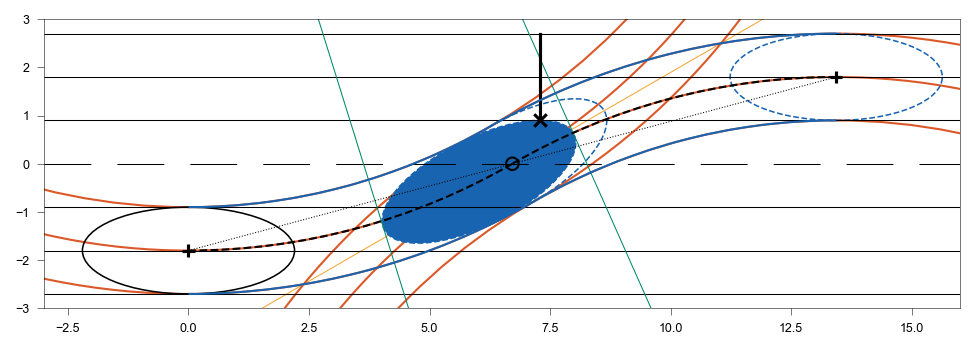

In [13]:
fig, ax = plt.subplots(figsize=(16 * params.cm, 6 * params.cm), dpi=150)
xmin = -3
xmax = 16
ymin = -3
ymax = 3
ax.set_aspect("equal")
ax.hlines(0, xmin=xmin, xmax=xmax, color="k", lw=0.5, ls=(0, (45, 25)))
ax.hlines(
    (
        -params.lane / 2 - params.car_w,
        -params.lane / 2,
        -params.lane / 2 + params.car_w,
        params.lane / 2 - params.car_w,
        params.lane / 2,
        params.lane / 2 + params.car_w,
    ),
    xmin=xmin,
    xmax=xmax,
    color="k",
    lw=0.5,
    ls=["-", "-"],
)
plt.axline((x_c, y_c), slope=np.tan(theta), c=orange, lw=0.5, zorder=-1)
merger.styles = {"ec": "k", "fc": "none", "fill": False, "lw": 0.75}
tangential = deepcopy(merger)
tangential.styles = {"ec": dark_blue, "fc": dark_blue, "fill": True, "lw": 0.75, "ls": "--"}
tangential.x = R * (np.sin(solution))
tangential.y = R * (1 - np.cos(solution)) - params.lane / 2
tangential.theta = solution
critical = deepcopy(merger)
critical.styles = {"ec": dark_blue, "fc": "none", "fill": False, "lw": 0.75, "ls": "--"}
critical.x = x_c
critical.y = y_c
critical.theta = theta
desired = deepcopy(merger)
desired.styles = {"ec": dark_blue, "fc": "none", "fill": False, "lw": 0.75, "ls": "--"}
desired.x = x_d
desired.y = y_d
desired.theta = 0
circle1 = plt.Circle((x_0, y_0), R, ec=vermilion, fc="none")
circle1_min = plt.Circle((x_0, y_0), r_min, ec=vermilion, fc="none")
circle1_max = plt.Circle((x_0, y_0), r_max, ec=vermilion, fc="none")
circle2 = plt.Circle((x_d, -y_0), R, ec=vermilion, fc="none")
circle2_min = plt.Circle((x_d, -y_0), r_min, ec=vermilion, fc="none")
circle2_max = plt.Circle((x_d, -y_0), r_max, ec=vermilion, fc="none")
ax.add_patch(circle1)
ax.add_patch(circle1_min)
ax.add_patch(circle1_max)
ax.add_patch(circle2)
ax.add_patch(circle2_min)
ax.add_patch(circle2_max)
arc1 = Arc((x_0, y_0), R * 2, R * 2, theta1=-90, theta2=-90 + np.degrees(theta), zorder=100, color="k", ls="--")
arc1_min = Arc(
    (x_0, y_0), r_min * 2, r_min * 2, theta1=-90, theta2=-90 + np.degrees(theta), zorder=100, color=dark_blue
)
arc1_max = Arc(
    (x_0, y_0), r_max * 2, r_max * 2, theta1=-90, theta2=-90 + np.degrees(theta), zorder=100, color=dark_blue
)
arc2 = Arc((x_d, -y_0), R * 2, R * 2, theta1=90, theta2=90 + np.degrees(theta), zorder=100, color="k", ls="--")
arc2_min = Arc((x_d, -y_0), r_min * 2, r_min * 2, theta1=90, theta2=90 + np.degrees(theta), zorder=100, color=dark_blue)
arc2_max = Arc((x_d, -y_0), r_max * 2, r_max * 2, theta1=90, theta2=90 + np.degrees(theta), zorder=100, color=dark_blue)
ax.add_patch(arc1)
ax.add_patch(arc1_min)
ax.add_patch(arc1_max)
ax.add_patch(arc2)
ax.add_patch(arc2_min)
ax.add_patch(arc2_max)
merger.draw(ax)
tangential.draw(ax)
critical.draw(ax)
desired.draw(ax)
tx = np.arctan(-(v / h) * 1 / np.tan(-tangential.theta + np.pi / 2))
ty = np.arctan(-(v / h) * 1 / np.tan(-tangential.theta))
ta = np.arcsin(v / R)
xx = h * np.cos(tx) * np.cos(tangential.theta) - v * np.sin(tx) * np.sin(tangential.theta)
yx = h * np.cos(tx) * np.sin(tangential.theta) + v * np.sin(tx) * np.cos(tangential.theta)
xy = h * np.cos(ty) * np.cos(tangential.theta) - v * np.sin(ty) * np.sin(tangential.theta)
yy = h * np.cos(ty) * np.sin(tangential.theta) + v * np.sin(ty) * np.cos(tangential.theta)
xa_f = h * np.cos(-ta) * np.cos(tangential.theta) - v * np.sin(-ta) * np.sin(tangential.theta)
ya_f = h * np.cos(-ta) * np.sin(tangential.theta) + v * np.sin(-ta) * np.cos(tangential.theta)
xa_r = h * np.cos(np.pi - ta) * np.cos(tangential.theta) - v * np.sin(np.pi - ta) * np.sin(tangential.theta)
ya_r = h * np.cos(np.pi - ta) * np.sin(tangential.theta) + v * np.sin(np.pi - ta) * np.cos(tangential.theta)
plt.axline((desired.x, -R + params.lane / 2), (tangential.x + xa_f, tangential.y + ya_f), lw=0.5, c=dark_teal)
plt.axline((0, R - params.lane / 2), (tangential.x + xa_r, tangential.y + ya_r), lw=0.5, c=dark_teal)
plt.scatter(tangential.x + xy, tangential.y + yy, ec="k", marker="x")
plt.scatter(x_m, y_m, marker="+", ec="k", fc="none", zorder=10)
plt.scatter(x_c, y_c, marker="o", ec="k", fc="none", zorder=10)
plt.scatter(x_d, y_d, marker="+", ec="k", fc="none", zorder=10)
plt.plot((x_m, x_d), (y_m, y_d), c="k", lw=0.5, ls=":")
plt.plot(
    (tangential.x + xy, tangential.x + xy),
    (tangential.w, 3 * tangential.w),
    c="k",
    lw=1.5,
)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
fig.tight_layout(pad=0)
# plt.savefig("./output/sketches/lane-change.pdf", format="pdf", transparent=True)

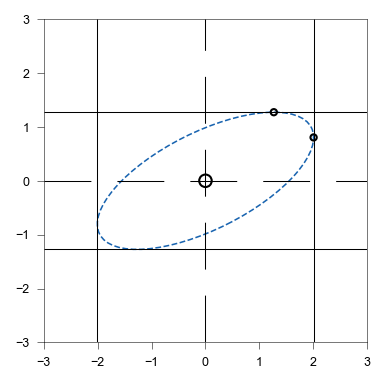

In [14]:
fig, ax = plt.subplots(figsize=(16 * params.cm, 6 * params.cm), dpi=150)
xmin = -3
xmax = 3
ymin = -3
ymax = 3
ax.set_aspect("equal")
ax.hlines(0, xmin=xmin, xmax=xmax, color="k", lw=0.5, ls=(0, (45, 25)))
ax.vlines(0, ymin=ymin, ymax=ymax, color="k", lw=0.5, ls=(0, (45, 25)))
ax.hlines(
    (
        -yy,
        yy,
    ),
    xmin=xmin,
    xmax=xmax,
    color="k",
    lw=0.5,
    ls=["-", "-"],
)

tangential = deepcopy(merger)
tangential.styles = {"ec": dark_blue, "fc": "none", "fill": True, "lw": 0.75, "ls": "--"}
tangential.x = 0
tangential.y = 0
tangential.theta = solution
tangential.draw(ax)

ax.vlines((-xx, xx), ymin=ymin, ymax=ymax, color="k", lw=0.5)
plt.scatter(xx, yx, marker=".", ec="k", fc="none", zorder=100)
plt.scatter(xy, yy, marker=".", ec="k", fc="none", zorder=100)
plt.scatter(0, 0, marker="o", ec="k", fc="none", zorder=100)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
fig.tight_layout(pad=0)
# plt.savefig("./output/sketches/lane-change.pdf", format="pdf", transparent=True)

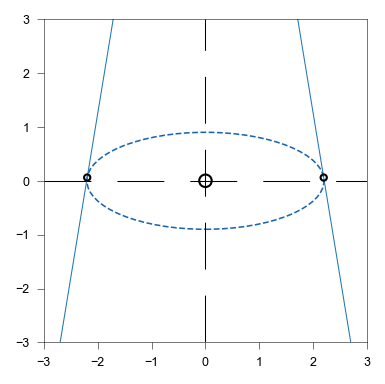

In [15]:
fig, ax = plt.subplots(figsize=(16 * params.cm, 6 * params.cm), dpi=150)
xmin = -3
xmax = 3
ymin = -3
ymax = 3
ax.set_aspect("equal")
ax.hlines(0, xmin=xmin, xmax=xmax, color="k", lw=0.5, ls=(0, (45, 25)))
ax.vlines(0, ymin=ymin, ymax=ymax, color="k", lw=0.5, ls=(0, (45, 25)))
origin = deepcopy(merger)
origin.styles = {"ec": dark_blue, "fc": "none", "fill": True, "lw": 0.75, "ls": "--"}
origin.x = 0
origin.y = 0
origin.theta = 0
origin.draw(ax)
plt.scatter(0, 0, marker="o", ec="k", fc="none", zorder=100)
xa = h * np.cos(ta)
ya = v * np.sin(ta)
plt.axline((0, R), (xa, ya), lw=0.5)
plt.axline((0, R), (-xa, ya), lw=0.5)
plt.scatter(xa, ya, marker=".", ec="k", fc="none", zorder=100)
plt.scatter(-xa, ya, marker=".", ec="k", fc="none", zorder=100)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
fig.tight_layout(pad=0)
# plt.savefig("./output/sketches/lane-change.pdf", format="pdf", transparent=True)